In [8]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [9]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Enformer_feature_0504.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_CTCF,K562_H3K27ac,HepG2_H3K27ac,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,0.082,0.682,1.078,3.238,1.168,0.860,1.123,0.272,0.605,0.681,0.715,1.879,0.781,1.102,0.131,0.637,0.744,0.913,1.453,1.293,0.935,0.894,0.087,0.704,1.485,0.729,1.389,1.605,1.075,0.998,0.144,0.304,1.092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,0.085,0.668,1.079,3.574,1.123,0.851,1.135,0.279,0.596,0.614,0.766,1.965,0.771,1.085,0.151,0.680,0.955,0.935,1.733,1.328,0.923,0.925,0.095,0.706,1.537,0.769,1.433,1.644,1.053,1.033,0.156,0.309,1.098,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,0.048,0.638,1.514,0.319,0.892,1.641,0.938,0.060,0.592,1.427,0.518,0.690,2.527,1.100,0.039,0.875,1.815,1.131,1.625,1.552,1.791,1.100,0.110,0.880,1.006,1.352,1.502,1.488,1.745,1.126,0.066,0.274,1.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,0.056,0.654,1.568,0.356,0.936,1.596,1.023,0.065,0.606,1.577,0.638,0.756,1.587,1.188,0.048,0.939,3.291,1.087,1.905,1.715,1.789,1.207,0.139,0.939,1.271,1.322,1.982,1.704,1.768,1.203,0.083,0.281,1.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,0.018,0.579,0.514,0.312,0.604,1.341,0.756,0.051,0.644,0.798,0.374,0.635,2.041,1.088,0.063,0.816,0.452,1.946,1.014,1.305,1.562,0.916,0.043,0.814,0.744,1.322,0.963,1.608,2.523,1.021,0.035,0.288,0.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135362,TATTGGCTATTGTGAATAGTACAGCAATAACACAGGAATACAGATA...,11:99513857:G:C:R:wC,chr11,99513857,G,C,ref,OL41_42,GTEx,-0.847,-0.821,-0.381,NaN,-0.425,0.022,0.502,0.600,0.357,0.478,0.695,0.684,0.032,0.536,0.457,0.710,0.411,0.768,0.731,0.062,0.907,2.006,1.058,1.825,1.958,1.349,1.011,0.047,0.604,1.074,0.770,1.429,1.509,0.894,0.981,0.024,0.268,0.596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135363,AATGTATGTCAAAAGTTTTTTTCTATTGTCATGAAGCAAAATATTA...,11:99609677:T:C:A:wC,chr11,99609677,T,C,alt,OL41_42,GTEx,-0.982,-0.519,-0.611,NaN,-0.534,0.033,0.607,0.498,0.392,0.974,1.304,0.776,0.044,0.612,0.519,0.516,0.649,1.277,0.957,0.058,0.811,0.887,1.038,1.381,1.843,1.685,1.037,0.053,0.675,0.886,1.026,0.913,1.386,1.347,0.998,0.026,0.248,0.648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135364,AATGTATGTCAAAAGTTTTTTTCTATTGTCATGAAGCAAAATATTA...,11:99609677:T:C:R:wC,chr11,99609677,T,C,ref,OL41_42,GTEx,-0.251,-0.474,-0.783,NaN,-0.410,0.034,0.572,0.466,0.414,0.969,1.158,0.754,0.043,0.581,0.485,0.534,0.622,1.074,0.873,0.062,0.815,0.826,1.125,1.359,1.723,1.566,1.025,0.049,0.720,0.837,0.971,0.896,1.357,1.654,0.948,0.028,0.276,0.652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135365,TCAATGATAAAACATTCCGTGCATAGTACAGTTTAAAGTCCCAGCA...,11:99622387:T:C:A:wC,chr11,99622387,T,C,alt,OL41_42,GTEx,-0.241,0.042,0.429,NaN,-0.339,0.019,0.534,0.541,0.426,0.592,0.887,0.702,0.047,0.694,0.560,2.018,0.453,0.802,0.888,0.116,

In [10]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

In [11]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

In [12]:
# for j, assay in enumerate(assays):
#     plt.figure(figsize=(8, 6), dpi=50)
#     plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
#     for i, cell_type in enumerate(cell_types):
#         x = MPRA_df[f'{cell_type}_{assay}']
#         sns.kdeplot(x, label=cell_type)
#     # plt.xlim(-0.5, 5)
#     plt.xlabel(f'{assay}')
#     plt.legend()
#     plt.savefig(f'figures/Gosai_MPRA_Enformer_{assay}_distribution.png', dpi=400)
#     plt.show()

In [13]:
# normalize between different cell types and assays

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        x = MPRA_df[f'{cell_type}_{assay}']
        condition = data_split_dict['train']
        x_train = x[condition]

        x_mean = np.mean(x_train)
        x = x / x_mean

        ######
        x[x<0] = 0
        ######

        MPRA_df[f'{cell_type}_{assay}'] = x

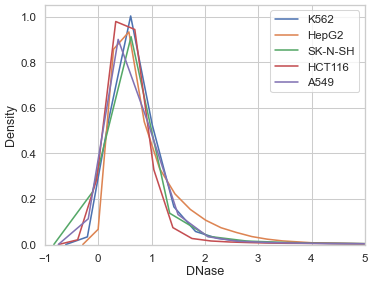

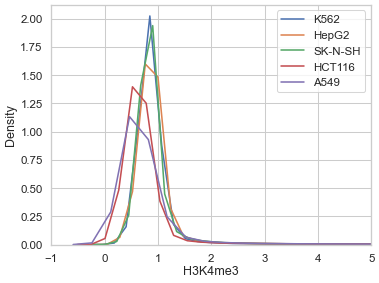

/tmp/ipykernel_7633/89349542.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)
/tmp/ipykernel_7633/89349542.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)
/tmp/ipykernel_7633/89349542.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


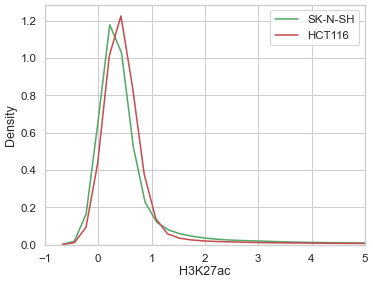

/tmp/ipykernel_7633/89349542.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


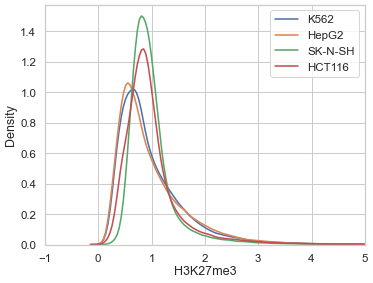

/tmp/ipykernel_7633/89349542.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


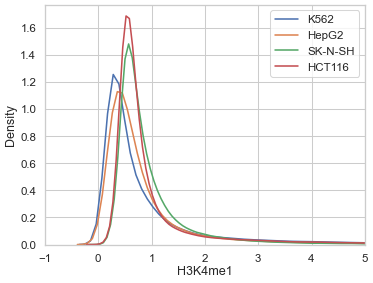

/tmp/ipykernel_7633/89349542.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


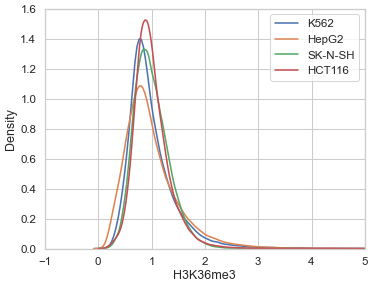

/tmp/ipykernel_7633/89349542.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


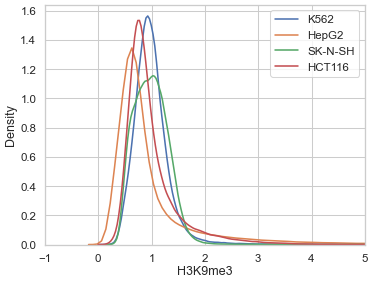

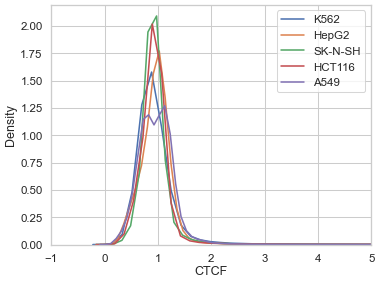

In [15]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = MPRA_df[f'{cell_type}_{assay}']
        sns.kdeplot(x, label=cell_type)
    plt.xlim(-1, 5)
    plt.xlabel(f'{assay}')
    plt.legend()
    # plt.savefig(f'figures/Gosai_MPRA_Sei_{assay}_distribution_norm.png', dpi=400)
    plt.show()

In [16]:
MPRA_df.to_csv('../data/Gosai_MPRA/Gosai_MPRA_Enformer_feature_0504_norm.csv', index=False)

In [ ]:
MPRA_df = pd.read_csv('../data/SirajMPRA/SirajMPRA_562654.csv')
MPRA_df

,description,seq,A549,HepG2,K562,SK-N-SH,HCT116,is_ref,chr,pos,ref,alt,start,end,585605_index
0,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.668,-0.704,0.539,0.159,True,chr1,14677,G,A,14577,14777,0
1,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.416,0.554,0.442,-0.288,False,chr1,14677,G,A,14577,14777,1
2,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.270,-0.391,0.752,1.100,True,chr1,63697,T,C,63597,63797,2
3,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.152,-0.659,0.205,1.051,False,chr1,63697,T,C,63597,63797,3
4,chr1:64764:C:T,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,NaN,-0.211,-0.007,0.499,0.258,True,chr1,64764,C,T,64664,64864,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562649,chrX:155233098:T:C,ATCATTTACTGGTGACTGCCCTGCTAGGGTGTCAGCTGTCAGATCC...,NaN,0.616,1.927,0.798,1.035,False,chrX,155233098,T,C,155232998,155233198,585600
562650,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,1.410,0.556,2.843,1.496,True,chrX,155233794,A,G,155233694,155233894,585601
562651,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,0.895,-0.073,1.974,0.795,False,chrX,155233794,A,G,155233694,155233894,585602
562652,chrX:155234730:T:C,TGGTGAGTTGCTTCTGTGCACACACTTTTGTTTATGAGTGTGCATG...,NaN,0.312,0.166,-0.041,0.444,True,chrX,155234730,T,C,155234630,155234830,585603


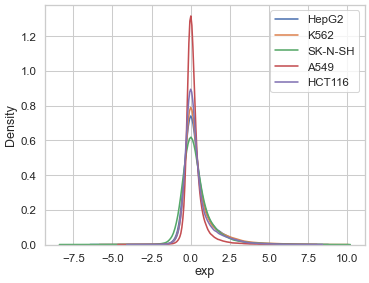

In [ ]:
plt.figure(figsize=(8, 6), dpi=50)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type]
    sns.kdeplot(x, label=cell_type)
plt.xlabel(f'exp')
plt.legend()
plt.show()

In [ ]:
# normalize between different cell types
MPRA_df_norm = MPRA_df.copy()

for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type].copy()
    condition = data_split_dict['train']
    x_mean = np.mean(x[condition])
    x_std = np.std(x[condition])
    x = (x - x_mean) / x_std
    MPRA_df_norm[cell_type] = x

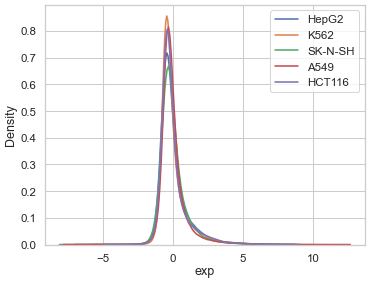

In [ ]:
plt.figure(figsize=(8, 6), dpi=50)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df_norm[cell_type]
    sns.kdeplot(x, label=cell_type)
plt.xlabel(f'exp')
plt.legend()
plt.show()

In [ ]:
MPRA_df_norm.to_csv('../data/SirajMPRA/SirajMPRA_562654_norm.csv', index=False)